In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
print(f"sklearn version : {sklearn.__version__}")

# just adding a comment
Project = 'spaceship-titanic'

#/kaggle/working
initial_directory = os.getcwd()
online = True if initial_directory=='/kaggle/working' else False
#/kaggle
parrent_directory = os.path.split(initial_directory)[0]
#whether we are working online or locally,os.path.join allows us to deal easily with 

train_file = os.path.join(parrent_directory,'kaggle','input',Project,"train.csv")
test_file = os.path.join(parrent_directory,'kaggle','input',Project,"test.csv")
print(train_file,"\n",test_file)

In [8]:
Debugg=False

In [13]:
def add_new_variables(data):
    data['Group'] = data.PassengerId.apply(lambda x : x[0:4])
    data['Group'] = data.groupby('Group')['Group'].transform('count')

    Luxury_variables = ['RoomService','Spa','VRDeck','FoodCourt','ShoppingMall']
    data["Luxury"] = data[Luxury_variables].sum(axis=1)

    data["nbnan"] = data.isnull().sum(axis=1)
    
    data['last_name'] = data['Name'].apply(lambda x:str(x).split(" ")[-1])
    data.last_name.value_counts()
    data['N_Familly_members'] = data.groupby('last_name')['last_name'].transform('count')
    #data['Luxury_Familly'] = data.groupby('last_name')['Luxury'].transform('sum')
    data.set_index('PassengerId')
    
    newvars  = pd.DataFrame(data["Cabin"].str.split('/', expand=True).values,columns=['Cabin_Deck','Cabin_Number','Cabin_Side'])
    data = pd.concat([data,newvars],axis=1)
    return data

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k,reverse=False):
    if(reverse==False):
        z = np.array(arr)[0:k]
    else:
        z = np.array(arr)[-k-1:]
    return np.sort(z)

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances=None, k=None,reverse=False):
        self.feature_importances = feature_importances
        self.k = k
        self.reverse = reverse
    def fit(self, X, y=None):
        if(self.feature_importances!=None):
            self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k,self.reverse)     
                
        return self
    def transform(self, X):
        if(self.feature_importances!=None and self.k!=None):
            return X[:, self.feature_indices_]
        else :
            return X

In [15]:
data = pd.read_csv(train_file)
data_sub = pd.read_csv(test_file)

if(Debugg):
    data = data.iloc[:30]
    data_sub = data_sub.iloc[:30]
X_sub = data_sub

data = add_new_variables(data)
data_sub = add_new_variables(data_sub)
X_sub = add_new_variables(X_sub)

Target_name = 'Transported'
y = data[Target_name]
X = data.drop(columns=[Target_name])

#"nbnan","ShoppingMall"
columns_to_drop = ["Cabin","Name",'last_name']
X = X.drop(columns=columns_to_drop)
X_sub = X_sub.drop(columns=columns_to_drop)

X = X.drop(columns=['PassengerId'])

numerical_columns = X.select_dtypes(exclude=['object']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

def clean_data(dt):
    #we first use the information we have gathered so far:
    #People from Cabin_Deck==G are al from Europa as shown from : sns.histplot(data=data,x='Cabin_Deck',hue='HomePlanet')
    mask1 = (dt['Cabin_Deck']=='G')
    mask2 = dt.HomePlanet.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'HomePlanet'] = 'Earth' 
    
    mask1 = (dt['HomePlanet']=='Earth')
    mask2 = dt.Cabin_Deck.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'Cabin_Deck'] = 'G' 
    
    # Il n'y a pas de VIP qui ont Earth en HomePlanet : sns.catplot(data=data,x='VIP',col='HomePlanet',kind='count')
    mask1 = (dt['HomePlanet']=='Earth')
    mask2 = dt.VIP.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'VIP'] = False
    
    # aucun des VIP n'est en CryoSleep : sns.histplot(data=X,y='VIP',hue='CryoSleep',multiple='stack')
    mask1 = (dt['CryoSleep']==False)
    mask2 = dt.VIP.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'VIP'] = True 
    
    mask = (dt['VIP']==True)
    mask2 = dt.CryoSleep.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'CryoSleep'] = False
    
    # les gends des decks A B et C sont tous d'europe : sns.histplot(data=data,x='Cabin_Deck',hue='HomePlanet')
    mask1 = (dt.Cabin_Deck.isin(['A','B','C']))
    mask2 = dt.HomePlanet.isnull()
    mask = (mask1) & (mask2)
    dt.loc[mask,'HomePlanet']='Europa'
    
    #Les enfants d'un Age nférieur ou égal à 12 ans n'ont rien dépensé
    mask1 = dt.Age<=12
    for col in ['RoomService','Spa','VRDeck','FoodCourt','ShoppingMall']:
        mask2 = dt[col].isnull()
        mask = (mask1) & (mask2)
        dt.loc[mask,col]= 0
        
    
    Luxury_variables = ['RoomService','Spa','VRDeck','FoodCourt','ShoppingMall']
    dt["Luxury"] = dt[Luxury_variables].sum(axis=1)
    
    dt.loc[(dt.CryoSleep.isnull()) & (dt.Luxury == 0), 'CryoSleep'] = True
    dt.loc[(dt.CryoSleep.isnull()) & (dt.Luxury != 0), 'CryoSleep'] = False
    
    # si l'age est manquant, le selectionner sur la base des habitants de la meme planete    
    dt['Age']=dt['Age'].fillna(dt.groupby('HomePlanet')['Age'].transform("median"))
    
    dt[numerical_columns] = dt[numerical_columns].fillna(dt[numerical_columns].median())
    dt[categorical_columns] = dt[categorical_columns].fillna('Unknown').astype('string')
    return dt

X = clean_data(X)
X_sub = clean_data(X_sub)

<AxesSubplot:>

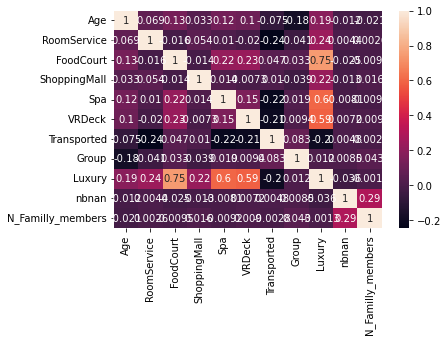

In [16]:
import seaborn as sns
sns.heatmap(data.corr(),annot=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

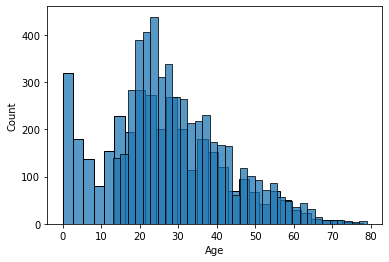

In [17]:
fig,ax = plt.subplots()
sns.histplot(data=data[data.Luxury==0],x='Age',ax=ax)
sns.histplot(data=data[data.Luxury!=0],x='Age',ax=ax)

In [18]:
clean_data(data).isnull().sum()

PassengerId            0
HomePlanet             0
CryoSleep              0
Cabin                199
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Name                 200
Transported            0
Group                  0
Luxury                 0
nbnan                  0
last_name              0
N_Familly_members      0
Cabin_Deck             0
Cabin_Number           0
Cabin_Side             0
dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='count'>

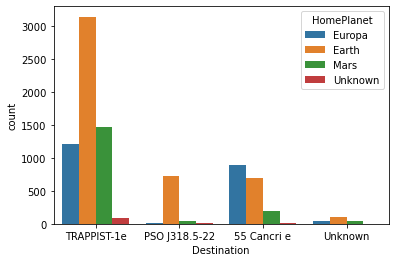

In [19]:
sns.countplot(data=data,x='Destination',hue='HomePlanet')

In [ ]:
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

categorical_preprocessor = Pipeline([
    #('impcat',SimpleImputer()),#,strategy='constant',fill_value="missing_value")),  # ca ne marche pas car mussing_value set considéré comme un string alors que les autres variables sont objet.
    ('enc',OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)),
     ])

numerical_preprocessor = Pipeline([
    #('impnum',SimpleImputer(missing_values=np.nan, strategy='median')),
    ('sca',StandardScaler()),
])
    
preprocessor = ColumnTransformer(
    [
        ('cat_preprocessor', categorical_preprocessor, categorical_columns),
        ('num_preprocessor', numerical_preprocessor, numerical_columns),
       
    ],#sparse_threshold=0, remainder='passthrough',
)

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

#from xgboost import XGBClassifier
classifier = RandomForestClassifier(n_estimators=400, max_leaf_nodes=10,n_jobs=-1, random_state=42)
#classifier = SGDClassifier(alpha=0.01,random_state=42)
#classifier = HistGradientBoostingClassifier(learning_rate=0.005, max_leaf_nodes=20, early_stopping=True, n_iter_no_change=5, max_iter=1000)

estimators = [
    ("hist",HistGradientBoostingClassifier(learning_rate=0.005, max_leaf_nodes=20, early_stopping=True, n_iter_no_change=5, max_iter=1000,random_state=42)),
    ("forest",RandomForestClassifier(bootstrap=True,n_estimators=600,max_depth=16,max_leaf_nodes=10,n_jobs=-1, random_state=42,min_samples_leaf=1)),
   # ("knn",KNeighborsClassifier(n_neighbors=40)),
    #("sgd",SGDClassifier(alpha=0.01,random_state=42)),
    #("log",LogisticRegression(random_state=42,max_iter=1000)),
   # ("xgb",XGBClassifier(eta=0.005,max_depth=10))
]
classifier = VotingClassifier(estimators, voting='soft')


model = Pipeline([
    ("preprocessor", preprocessor),
    ("TopFeatureSelector",TopFeatureSelector(feature_importances=None, k=None)),
    ("classifier",  classifier),
])

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

cv_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=42) #mega important
cv_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=42) #mega important
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,shuffle=True)

model

In [ ]:
cv_results = cross_validate(model,X_train,y_train,cv=cv_outer,error_score='raise',scoring="balanced_accuracy", return_train_score=True)
for name in ["train", "test"]:
    r = cv_results[f'{name}_score'] 
    print(f"Score {name}: {r.mean():.3f} +/- {r.std():.3f}")
    
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model,X_train,y_train,cv=cv_outer)
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
confusion_matrix(y_train,y_train_pred)
print(f"precision_score = {precision_score(y_train,y_train_pred):.3f}")
print(f"recall_score = {recall_score(y_train,y_train_pred):.3f}")
print(f"f1_score = {f1_score(y_train,y_train_pred):.3f}")

In [ ]:
model.fit(X_train,y_train)

from sklearn.model_selection import RandomizedSearchCV

n_estimators = np.linspace(200,1000,100,dtype=int).tolist()
max_features = ['auto', 'sqrt']
max_depth = np.linspace(5, 30,26).tolist()+['None']
min_samples_leaf = [1, 2, 4,8]
bootstrap = [True, False]# Create the random grid

param_distributions = {
    'classifier__forest__n_estimators': n_estimators,
    'classifier__forest__max_features': max_features,
    'classifier__forest__max_depth': max_depth,
    'classifier__forest__min_samples_leaf': min_samples_leaf,
    'classifier__forest__bootstrap': bootstrap
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=30,cv=cv_inner, verbose=1,n_jobs = -1,scoring='balanced_accuracy'
)


model_random_search.fit(X_train,y_train)
    
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values("mean_test_score", ascending=False)

shorten_param = lambda param_name: param_name.rsplit("__", 1)[1] if "__" in param_name else param_name
    
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

from pprint import pprint
print("The best parameters are:")
pprint(model_random_search.best_params_)
print(f"\n with a mean test score (accuracy) of : {cv_results.iloc[0]['mean_test_score']:.3f} +- {cv_results.iloc[0]['std_test_score']:.3f}")


In [ ]:
#model = model_random_search.best_estimator_ # we select the best model 

We can check how this model performs on our test data sample

It's normal for the score to be smaller

In [ ]:
#model.fit(X_train,y_train)
accuracy = model.score(X_test,y_test)
print(f"The test accuracy score of the best model is {accuracy:.3f}")

Note that by refitting the model on the whole train data set, we get the same accuracy. That is because once the outer/iner cross validation is performed with the randomized search, the algorithm automatically Refits the full train data set with the best parameters found

faire un cross validate sur des données où on a fait un hyper parameter tuning a t il du sens ? ca me parait un peu biaisé


un nested cross validation permet d'estimer les generalistions de performances mais au final ne permet pas de décider exactement quels hyperparametrezs utiliser. En effet, prenons l'exemple d'une outer loop de 5 folds. Pour chaque outer fold, on a un test set et un train set. Le train set est dedécoupé en X inner folds pour l'hyperparameter tunning et une fois les best parameters trouvés, le modele est reentrainé sur tout le train set de cet inner fold et le score déterminé sur le test set.

A chaque outer fold, on refait cette procédure mais il n'y a aucune raison pour que les hyperparametres soient les memes d'un outerfold à un autre. 

#cela n'a en principe aucun sens de refaire un cross validate su X_train,y_train. En effet, admettons qu'on utilise le meme cv avec le meme random state:
# on va refaire les meme folds lors du parameter tunning et vu que les best parameters obtenus faisaient evidemment parti de ceux testes
# on va se retrouver avec le meme score.

# par contre ce qui peut faire sens, c'est qu'on a arbitraiement pris un X_train et X_test via train test split au debut
# on peut faire un cross_validate sur X et y mais je sais pas pourquoi ce m'a pas l'air net.
# en meme temps on en a besoin pour comparer les train et test scores poru checker overfitting....

#model.set_params(classifier__l2_regularization=1000)
cv_results = cross_validate(model,X_train,y_train,cv=cv_outer,error_score='raise',scoring="balanced_accuracy", return_train_score=True)
for name in ["train", "test"]:
    r = cv_results[f'{name}_score'] 
    print(f"Score {name}: {r.mean():.3f} +/- {r.std():.3f}")

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [ ]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=30)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
model[1].feature_importances = list(sorted_importances_idx)
model[1].k = 17
model[1].reverse = True
cv_results = cross_validate(model,X_train,y_train,cv=cv_outer,error_score='raise',scoring="balanced_accuracy", return_train_score=True)
for name in ["train", "test"]:
    r = cv_results[f'{name}_score'] 
    print(f"Score {name}: {r.mean():.3f} +/- {r.std():.3f}")
   

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model,X_train,y_train,cv=cv_outer)
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
confusion_matrix(y_train,y_train_pred)
print(f"precision_score = {precision_score(y_train,y_train_pred):.3f}")
print(f"recall_score = {recall_score(y_train,y_train_pred):.3f}")
print(f"f1_score = {f1_score(y_train,y_train_pred):.3f}")

In [ ]:
#model = GradientBoostingClassifier()
model.fit(X, y)
submission_predictions = model.predict(X_sub)

output = pd.DataFrame({'PassengerId': X_sub.PassengerId, 'Transported': submission_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")